<a href="https://colab.research.google.com/github/mae-tafoya/DS-work/blob/master/Project4_Mae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 4

Mae Tafoya - Cohort 3

#Problem Definition

Find out which famous people are similar to one another by analyzing their biography. 

By using natural language processing techniques and K Nearest Neighbors, we can recommend ten similar individuals who have similar biographies.

#Data Collection

Install or import any necessary libraries to be used throughout the notebook.

In [126]:
pip install nltk

In [127]:
pip install wikipedia

In [128]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import random
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.neighbors import NearestNeighbors
import wikipedia

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The dataset that will be used consists of 42785 different people and their bios. The 3 columns in the dataframe are 'URI', Name, and 'Text'.

In [130]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Project 4 data/Copy of project_4.csv')

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42786 entries, 0 to 42785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   URI     42786 non-null  object
 1   name    42786 non-null  object
 2   text    42786 non-null  object
dtypes: object(3)
memory usage: 1002.9+ KB


In [131]:
df.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


#Data Cleaning

Make a copy of the data to begin cleaning.

In [9]:
corpus = df.copy()

In [10]:
#drop 'URI' column. Will not be needing it for processing
corpus.drop('URI', axis=1, inplace=True)

#EDA

Calculate the sentiment score for all the bios in the dataset. Add a column for each score.

In [133]:
sub = lambda x: TextBlob(x).sentiment.subjectivity

corpus['subjectivity'] = corpus['text'].apply(sub)

Remove stop words

In [29]:
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1), # considering only 1-grams
                        min_df = 0.07,     # cut words present in less than 7% of documents
                        max_df = 0.4)      # cut words present in more than 40% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(corpus['text']) #fit the model

make a visual for top ranked words in the corpus

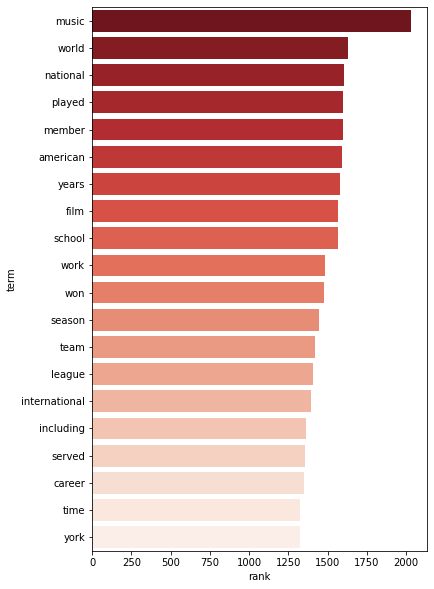

In [31]:
# define a function to call the top ranked words from the vectorizer above
def rank_words(terms, feature_matrix):
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)

fig, ax = plt.subplots(figsize=(6,10), ncols=1, nrows=1)
sns.barplot(x='rank',y='term',data=ranked[:20], palette='Reds_r', ax=ax);

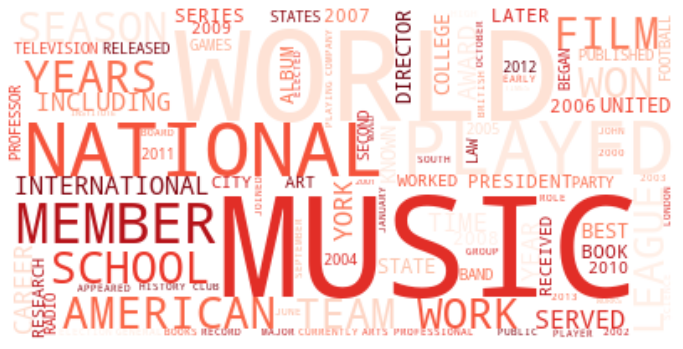

In [32]:
# For visualization, I will create a word cloud showing the word frequency
dic = {ranked.loc[i,'term'].upper(): ranked.loc[i,'rank'] for i in range(0,len(ranked))}

wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      colormap='Reds').generate_from_frequencies(dic)
fig = plt.figure(1,figsize=(12,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

Topic Modelling with Latent Dirichlet Allocation (LDA)



In [33]:
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics,random_state=0)

topics = lda.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(lda.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

{0: ['music', 'art', 'arts', 'work', 'artist'],
 1: ['world', 'won', 'championship', 'team', 'title'],
 2: ['research', 'professor', 'science', 'institute', 'phd'],
 3: ['radio', 'television', 'years', 'tv', 'family'],
 4: ['book', 'published', 'books', 'author', 'writing'],
 5: ['league', 'season', 'played', 'football', 'team'],
 6: ['film', 'album', 'music', 'band', 'released'],
 7: ['party', 'election', 'elected', 'member', 'served'],
 8: ['government', 'president', 'december', 'january', 'appointed'],
 9: ['law', 'served', 'president', 'board', 'united']}

Visualize the outcomes for LDA topic modeling.

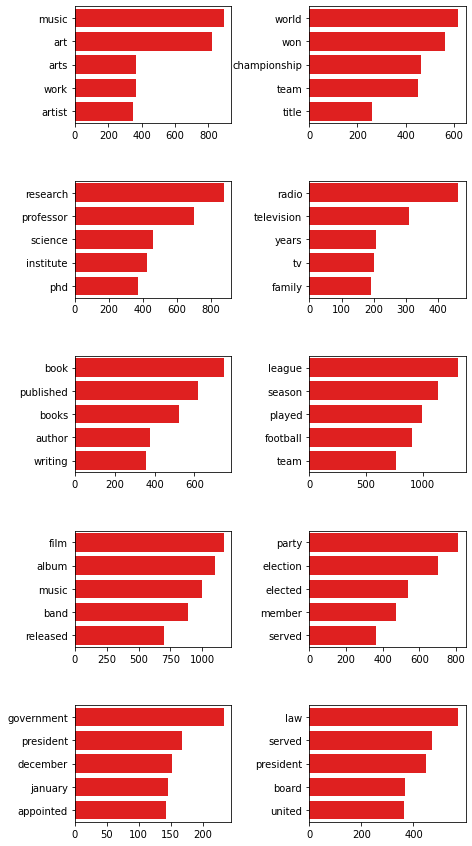

In [19]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

Try topic Modelling with Non-Negative Matrix Factorization (NMF)


In [20]:
n_topics = 10
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
t_words

{0: ['book', 'published', 'books', 'author', 'writing'],
 1: ['league', 'season', 'played', 'football', 'games'],
 2: ['album', 'band', 'released', 'record', 'known'],
 3: ['party', 'election', 'elected', 'member', 'politician'],
 4: ['film', 'television', 'series', 'award', 'role'],
 5: ['music', 'performed', 'festival', 'radio', 'studied'],
 6: ['art', 'work', 'artist', 'arts', 'york'],
 7: ['world', 'won', 'team', 'championship', 'title'],
 8: ['research', 'professor', 'science', 'institute', 'phd'],
 9: ['law', 'served', 'president', 'united', 'states']}

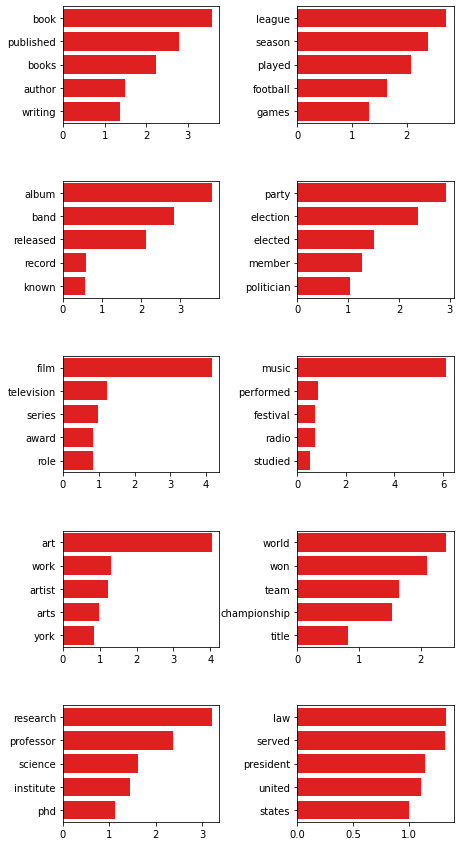

In [21]:
fig, ax = plt.subplots(figsize=(7,15), ncols=2, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,2):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

Looks like we have a slightly better topic separations using NMF.

Now that we can see some progress in groups by similarity, I can move forward with finding a nearest neighbor for a random person from the dataset.

#Data Processing

In [55]:
#select a random name from the list
namelist = corpus['name']
print("random name from list is: ", random.choice(namelist))

random name from list is:  Glynis Sweeny


Nearest Neighbors

In [36]:
#fit the Nearest Neighbor model here
nn = NearestNeighbors(metric = 'euclidean')
nn.fit(tfidf)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

Input famous person's name here:

In [37]:
George_Heller_index = corpus[corpus['name'] == 'George Heller'].index[0]

In [56]:
#use this for in class example
# Glynis_sweeny_index = corpus[corpus['name'] == 'Glynis Sweeny'].index[0]

In [40]:
#this line of code finds the 10 nearest neighboring famous people to the original input
distances, indices = nn.kneighbors(tfidf[George_Heller_index], n_neighbors = 10)

In [ ]:
#in class example
# distances, indices = nn.kneighbors(tfidf[Glynis_sweeny_index], n_neighbors = 10)

Here are the top ten nearest neighbors to George Heller.

In [41]:
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})
print(neighbors)

   distance     id
0  0.000000   6345
1  0.904841  25784
2  0.923604  15895
3  0.925133  14811
4  0.925557   5297
5  0.931244   1030
6  0.934042  15070
7  0.939200  38752
8  0.941758  16494
9  0.947192  24786


In [42]:
nearest_info = (corpus.merge(neighbors, right_on = 'id', left_index = True).sort_values('distance')[['id', 'name', 'distance']])
print(nearest_info)

      id                   name  distance
0   6345          George Heller  0.000000
1  25784     Cecil O. Samuelson  0.904841
2  15895  Oscar Vicente Scavone  0.923604
3  14811       Henry D. Edelman  0.925133
4   5297       Ted E. Brewerton  0.925557
5   1030        Rashid Gaysanov  0.931244
6  15070      Riccardo Fraccari  0.934042
7  38752            Joel Kocher  0.939200
8  16494        Stephen Feldman  0.941758
9  24786           Henry Lozano  0.947192


Check the sentiment score for accuracy

In [134]:
corpus.iloc[6345]

name                                                George Heller
text            george heller is a canadian businessperson he ...
polarity                                                    -0.04
subjectivity                                                 0.37
Name: 6345, dtype: object

In [72]:
corpus.iloc[25784]

name                                           Cecil O. Samuelson
text            cecil osborn samuelson jr born aug 1 1941 was ...
polarity                                                 0.134615
subjectivity                                             0.314103
Name: 25784, dtype: object

In [70]:
corpus.iloc[24786]

name                                                 Henry Lozano
text            henry lozano born august 24 1948 is a nonprofi...
polarity                                                 0.103333
subjectivity                                             0.373333
Name: 24786, dtype: object

Looking at the sentimate(subjectivity score) for three of the selected 'nearest neighbors', I can conlude that the model is giving an accurate output.

#Conclusion

I am able to successfully provide a recommendation of ten other biographies based on a single input. 

Moving forward some things to improve on:
- More detailed cleaning of the corpus text
- I will try more techniques on the text analysis, such as stemming, lemmitization etc.
- Work on writing better, more generic code that can be applied broadly (example: possibly writing a function for the famous person input with KNearestNeighbor model)
- More visualizations of the recommendation outcomes/sentiment scores